In [20]:
# downloading our data
# code copied from my other 
# VAE repo.
import torchvision

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256,256]),
    torchvision.transforms.ToTensor()
])

train_data = torchvision.datasets.Imagenette(
    'imagenette',
    split = 'train',
    download=False,
    transform=transform
)

In [38]:

transform2 = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256,256]),
    torchvision.transforms.ToTensor()
])

train_data2 = torchvision.datasets.CIFAR10(
    'cifar_10',
    train=True,
    download=False,
    transform=transform2
)
print(len(train_data2))

50000


torch.Size([3, 256, 256])


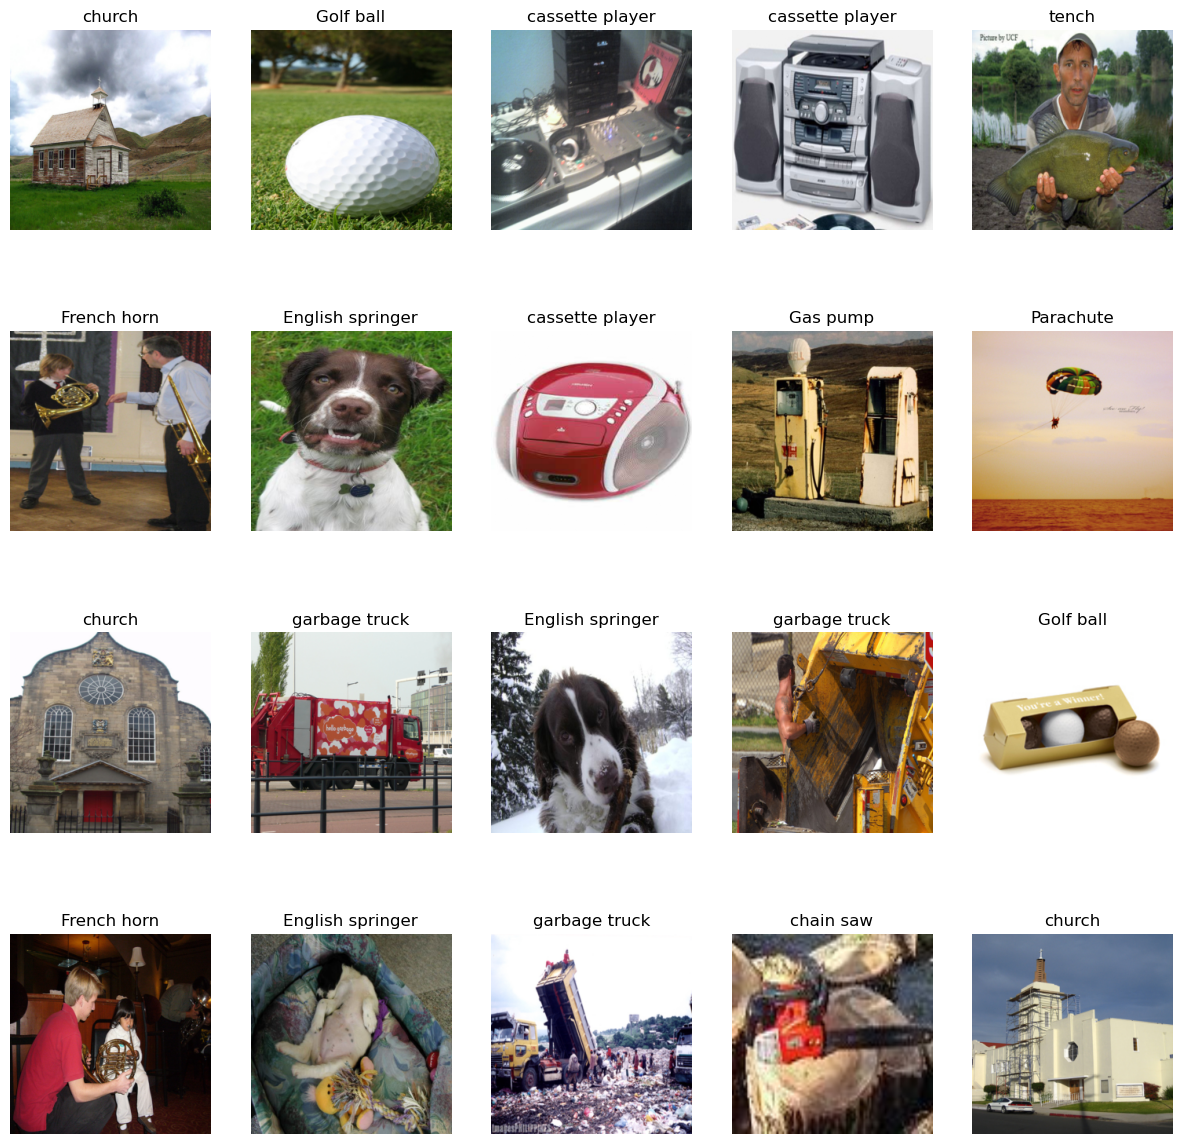

In [39]:
# not using custom dataset, bc don't need latents.
import matplotlib.pyplot as plt
import torch
label_map = {
    0: 'tench',
    1: 'English springer',
    2: 'cassette player',
    3: 'chain saw',
    4: 'church',
    5: 'French horn',
    6: 'garbage truck',
    7: 'Gas pump',
    8: 'Golf ball',
    9: 'Parachute'
}
print(train_data[0][0].shape)

fig,axes = plt.subplots(4,5)
fig.set_size_inches(15,15)
for i in range(20):
    ind = torch.randint(0,len(train_data),size=(1,)).item()
    axes[i//5][i%5].imshow(train_data[ind][0].permute(1,2,0))
    axes[i//5][i%5].set_title(label_map[train_data[ind][1]])
    axes[i//5][i%5].axis("off")

torch.Size([3, 256, 256])


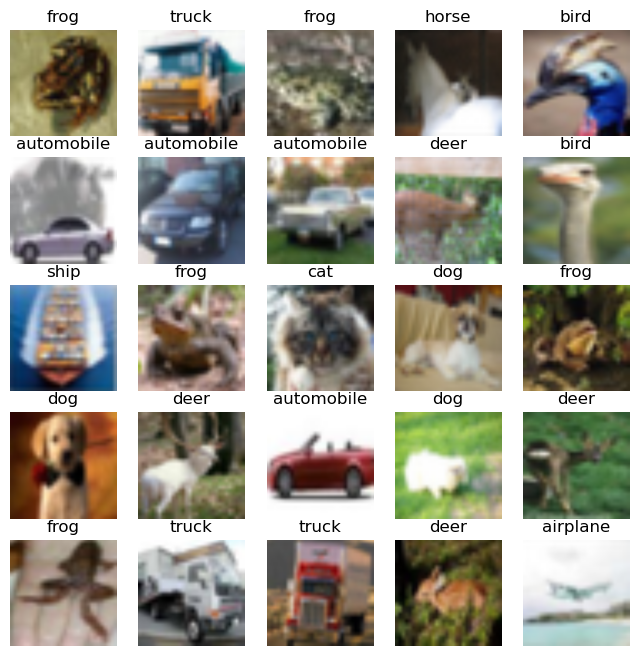

In [40]:
map_labels = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}
print(train_data2[0][0].shape)

fig,axes = plt.subplots(5,5)
fig.set_size_inches(8,8)
for i in range(25):
    ind = torch.randint(0,len(train_data2),size=(1,)).item()
    axes[i//5][i%5].imshow(train_data2[ind][0].permute(1,2,0))
    axes[i//5][i%5].set_title(map_labels[train_data2[ind][1]])
    axes[i//5][i%5].axis("off")

### Loading model weights

In [41]:
# doing path
import os
import sys
import torch
sys.path.append(os.path.abspath('../vq_vae_1'))
from vae import VQVAE

In [42]:
path = '../weights.pt'
model = VQVAE()
model.load_state_dict(torch.load(path))
model.eval()
print("Loaded")

Loaded


C:\Users\charl\AppData\Local\Temp\ipykernel_10284\2486652628.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


torch.Size([3, 256, 256]) torch.Size([3, 256, 256])
torch.Size([3, 256, 256]) torch.Size([3, 256, 256])
torch.Size([3, 256, 256]) torch.Size([3, 256, 256])
torch.Size([3, 256, 256]) torch.Size([3, 256, 256])
torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


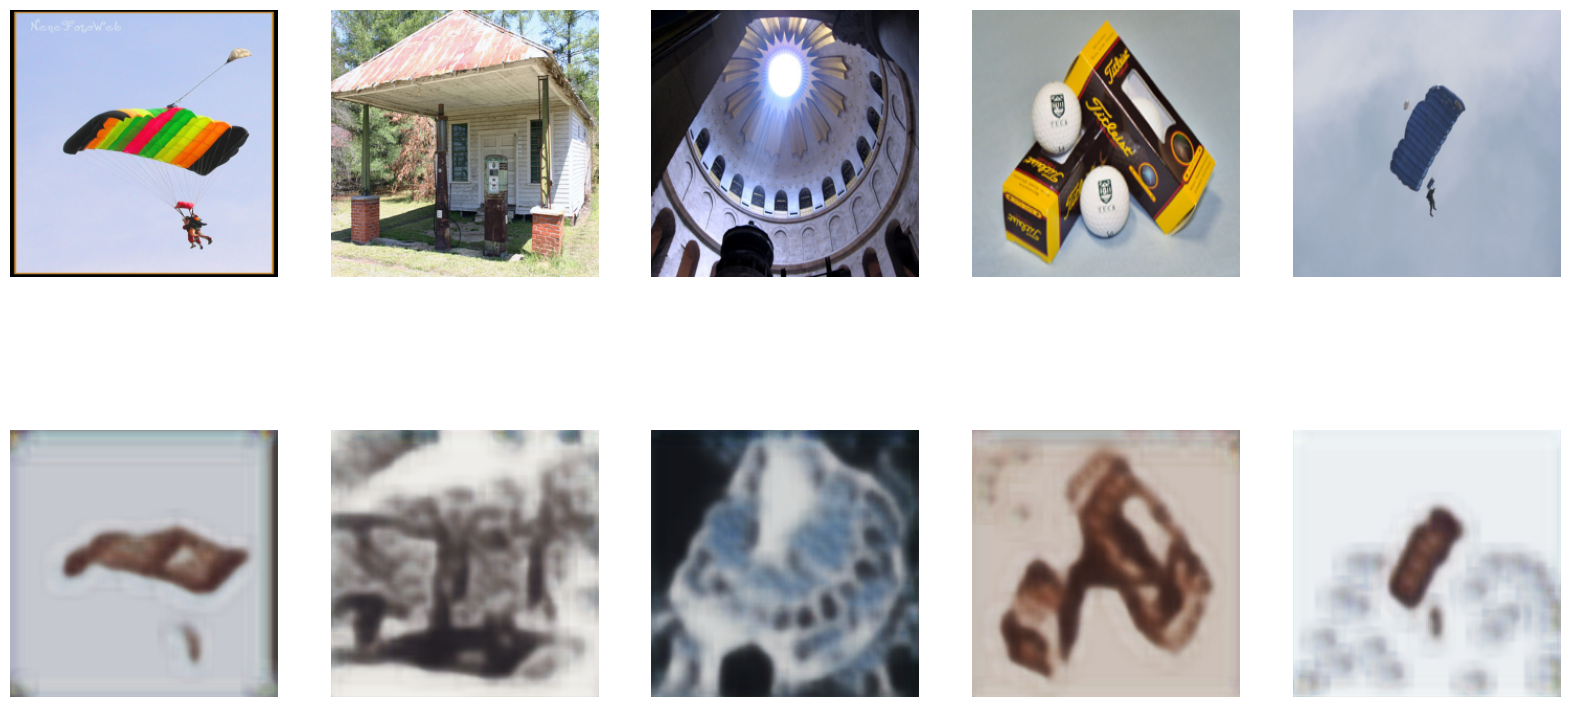

In [48]:
# testing-out model
import matplotlib.pyplot as plt
train_data =train_data # imagenette

fig,axes = plt.subplots(2,5)
fig.set_size_inches(20,10)

for i in range(5):
    ind = torch.randint(0,len(train_data),size=(1,)).item()
    axes[0][i%5].imshow(train_data[ind][0].permute(1,2,0))
    vae_out = model(train_data[ind][0].unsqueeze(0))[0].squeeze()
    vae_out = vae_out.to('cpu').detach()
    axes[1][i%5].imshow(vae_out.permute(1,2,0))
    axes[0][i%5].axis('off')
    axes[1][i%5].axis('off')
    
    print(vae_out.shape,train_data[ind][0].shape)
    

## Testing our VQ embedding choser

In [27]:
# tests to make sure shapes work
# all batch-dims combined
n_emb,d_emb = 400, 256
b,c,h,w  = 32,256,64,64

emb_weights = torch.randn([n_emb,d_emb])
conv_input = torch.randn([b,c,h,w])

# reshaping to have 1 'super dim'
# b,c,h,w -> b*h*w,c
conv_input = conv_input.permute(0,2,3,1).contiguous().view(b*h*w,c)

# calculating the squared product (l2 norm)
# emb,1
# b*h*w, 1
emb_squared = torch.sum(emb_weights**2,dim=-1,keepdim=True)
input_squared = torch.sum(conv_input**2,dim=-1,keepdim=True)

# emb,c @ c,b*h*w -> emb,b*h*w
emb_input_mul = -2*torch.matmul(conv_input,emb_weights.transpose(0,1))
# add all at right dims...
final = emb_squared.transpose(0,1) + emb_input_mul+ input_squared

# b*h*w,1 -> found max-indices
indices = torch.argmin(final,dim=-1,keepdim=True)

# b*h*w, emb
one_hot = torch.zeros(b*h*w,n_emb)
one_hot.scatter_(dim=1,index=indices,value=1)


one_hot[0][:], one_hot.shape # works!

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.,

In [28]:
# how to index with argmin vals?

# B,Emb,H*W -> B,1,H*W
t = torch.randn([3,20,4])
indices = torch.argmin(t,dim=1,keepdim=True)

print(indices) # B,1,h*w

# B,1,h*w
indices = torch.argmin(final,dim=1,keepdim=True)
indices.shape

tensor([[[ 8,  3, 14,  4]],

        [[ 5, 17, 18, 19]],

        [[19,  1,  6, 16]]])


torch.Size([131072, 1])

In [29]:
zeros = torch.zeros(2,5)
ind = torch.tensor([[0],[4]])

'''The dimension is how
each value inside indexes. 
The rest are over other dimensions,
so make-sure that these also match.

We can simply broadcast this across
multiple batches to acheive our desired
result.'''

# over 1st dim, we selct the indices


zeros.scatter_(dim=1,value=1,index=ind) 

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.]])

## Torch Autograd Expiriments

In [30]:
# with grad
v1 = torch.tensor([1.0],requires_grad=True)
v2 = torch.tensor([3.0],requires_grad=True)

loss = v1*v2 + v1
loss.backward()

# 4,1
print(v1.grad,v2.grad)

tensor([4.]) tensor([1.])


In [31]:
# WITHOUT (for first)
v1 = torch.tensor([1.0],requires_grad=True)
v2 = torch.tensor([3.0],requires_grad=True)

loss = v1.detach()*v2 + v1
loss.backward()

# 1,1 !!!
print(v1.grad,v2.grad)

tensor([1.]) tensor([1.])


In [32]:
# funny way to transfer gradients
v1 = torch.tensor([3.0],requires_grad=True)
v2 = torch.tensor([4.0],requires_grad=True)
v3 = torch.tensor([1.4],requires_grad=True)


# doing nothing, but swapping grads!
v3 = v1 + (v3-v1).detach() # takes out v3!
loss = v3*v2
loss.backward()

# V3 is overall severed
# from the graph now.
# all is on v1
v1.grad,v2.grad,v3.grad
# 4,1.4,None!

C:\Users\charl\AppData\Local\Temp\ipykernel_10284\1007201245.py:15: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen/core/TensorBody.h:494.)
  v1.grad,v2.grad,v3.grad


(tensor([4.]), tensor([1.4000]), None)